<a href="https://colab.research.google.com/github/LaisHott/funnel-ab-test-foodapp/blob/main/Notebook_Projeto_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Comportamento do Usuário e Teste A/A/B em um Aplicativo de Produtos Alimentícios

Este projeto é conduzido em uma startup que opera na venda de produtos alimentícios por meio de um aplicativo. Nosso objetivo é analisar o comportamento dos usuários no aplicativo, desde o momento em que entram até a conclusão de uma compra. Através do estudo do funil de vendas, investigaremos como os usuários interagem com diferentes etapas, quantos atingem a fase de compra e onde ocorrem quedas significativas. Além disso, estamos realizando um teste A/A/B para avaliar a possível introdução de novas fontes no aplicativo. Dividindo os usuários em grupos de controle e teste, buscaremos identificar se as mudanças de design afetam positivamente a experiência do usuário e as conversões. Através dessas análises, pretendemos tomar decisões embasadas para otimizar a usabilidade do aplicativo e melhorar as taxas de conversão.

# Inicialização

Vamos começar com as bibliotecas necessárias relevantes para nossa análise.

In [ ]:
# Carregando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency
import numpy as np

## Passo 1 - Abra o arquivo de dados e leia a informação geral

***Descrição dos dados***:

Cada entrada de diário é uma ação do usuário ou um evento.

`EventName` — Nome do evento

`DeviceIDHash` — Identificador de usuário exclusivo

`EventTimestamp` — Hora do evento

`ExpId` — Número do experimento: 246 e 247 são os grupos de controle, 248 é o grupo de teste

### Carregando os dados

Vamos armazenar os dados em variáveis específicas e, em seguida, otimizá-los para a análise, certificando-nos de que cada coluna contenha o tipo correto de dados.

In [ ]:
# Carregando os dados
diary_event = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

In [ ]:
# Analisando informações detalhadas sobre o dataframe
diary_event.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.9 MB


In [ ]:
# Verificando as primeiras linhas do Dataframe
diary_event.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Passo 2. Prepare os dados para análise

Vamos preparar os dados, renomeando as colunas para respeitar o padrão Python. Precisamos verificar se há valores ausentes e se os tipos de dados estão corretos.

Vamos adicionar uma coluna de data e hora e uma coluna separada para datas.

In [ ]:
# Renomeando as colunas
diary_event.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash',
                            'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'}, inplace=True)


In [ ]:
# Verificando dataframe após renomear as colunas
diary_event.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
diary_event.sort_values(by='event_name')

,event_name,device_id_hash,event_timestamp,exp_id
54817,CartScreenAppear,4623191541214045580,1564746333,247
171660,CartScreenAppear,147514000526855717,1565028133,248
171658,CartScreenAppear,2305766456715991733,1565028127,248
59316,CartScreenAppear,4207391824763599753,1564753932,247
171646,CartScreenAppear,147514000526855717,1565028088,248
...,...,...,...,...
33530,Tutorial,3755777888701401447,1564683541,247
31919,Tutorial,6279514806004087328,1564681000,247
155146,Tutorial,1266450414894434600,1565005188,247
232491,Tutorial,5208270606211794573,1565189508,248


In [ ]:
# Verificando valores ausentes e duplicados
diary_event.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

In [ ]:
# Verificando valores duplicados
diary_event.duplicated().sum()

413

In [ ]:
# Processando os duplicados
diary_event.drop_duplicates(inplace=True)

In [ ]:
# Verificando Dataframe após remoção das duplicatas
diary_event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


A coluna `event_timestamp` está sendo tratadas como int em vez do tipo de dado mais apropriado, como carimbo de data/hora. Vamos corrigir os tipos de dados para tipos mais apropriados.

In [ ]:
# Corrigindo os tipos de dados adequados
diary_event['event_timestamp'] = diary_event['event_timestamp'].astype('datetime64[ns]')

In [ ]:
# Verificando a correção
diary_event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


In [ ]:
diary_event.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1970-01-01 00:00:01.564029816,246
1,MainScreenAppear,7416695313311560658,1970-01-01 00:00:01.564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1970-01-01 00:00:01.564054127,248
3,CartScreenAppear,3518123091307005509,1970-01-01 00:00:01.564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1970-01-01 00:00:01.564055322,248


- O fato de não encontrar valores faltantes pode ser fundamental para garantir a integridade das análises estatísticas e das conclusões delas decorrentes. No nosso conjunto de dados, não identificamos valores ausentes e, em relação aos dados duplicados, optamos por removê-los.

- Vamos adicionar uma coluna de data e hora e uma coluna separada para datas. A coluna `eventTimestamp` convertida em carimbos de data/hora e uma nova coluna date que contém apenas a data sem a parte de hora.

In [ ]:
# Adicionando uma coluna separada para datas
diary_event['date'] = diary_event['event_timestamp'].dt.date

In [ ]:
# Adicionando uma coluna separada para data e hora
diary_event['date_time'] = diary_event['event_timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# Analisando a nova coluna criada
diary_event.head()

,event_name,device_id_hash,event_timestamp,exp_id,date,date_time
0,MainScreenAppear,4575588528974610257,1970-01-01 00:00:01.564029816,246,1970-01-01,1970-01-01 00:00:01
1,MainScreenAppear,7416695313311560658,1970-01-01 00:00:01.564053102,246,1970-01-01,1970-01-01 00:00:01
2,PaymentScreenSuccessful,3518123091307005509,1970-01-01 00:00:01.564054127,248,1970-01-01,1970-01-01 00:00:01
3,CartScreenAppear,3518123091307005509,1970-01-01 00:00:01.564054127,248,1970-01-01,1970-01-01 00:00:01
4,PaymentScreenSuccessful,6217807653094995999,1970-01-01 00:00:01.564055322,248,1970-01-01,1970-01-01 00:00:01


- Com os dados processados, otimizados e tipos corretamente ajustados, estamos prontos para iniciar nossas análises.

## Passo 3. Estude e verifique os dados

### Quantos eventos ficam nos diários?

Para determinar quantos eventos estão presentes nos diários, podemos usar a função *count()* do pandas na coluna `event_name`. Isso contará o número de eventos registrados no conjunto de dados.

In [ ]:
# Calculando o número total de eventos registrados nos diários
total_events = diary_event['event_name'].count()

In [ ]:
# Imprimindo o resultado
print("Total de eventos nos diários:", total_events)

Total de eventos nos diários: 243713


### Quantos usuários ficam nos diários?

Para determinar o número de usuários únicos presentes nos diários, podemos usar a função *nunique()* na coluna `device_id_hash`. Isso contará o número de identificadores únicos de usuários registrados no conjunto de dado.

In [ ]:
# Calculando o número total de eventos registados nos diários
total_users = diary_event['device_id_hash'].nunique()

In [ ]:
# Imprimindo o resultado
print("Total de usuários nos diários:", total_users)

Total de usuários nos diários: 7551


### Qual é o número médio de eventos por usuário?

Para calcular o número médio de eventos por usuário, podemos dividir o total de eventos pelo número total de usuários únicos.

In [ ]:
# Calculando o número médio de eventos por usuário
average_events_per_user = total_events / total_users

In [ ]:
# Imprimindo o resultado
print("Número médio de eventos por usuário:", average_events_per_user.round(3))

Número médio de eventos por usuário: 32.276


### Qual é o período de tempo que os dados cobrem? Encontre a data máxima e mínima. Desenhe um histograma por data e hora. Você pode ter certeza de que possui os dados igualmente completos para todo o período? Os eventos mais antigos podem acabar aparecendo nos diários de alguns usuários por motivos técnicos, e isso pode distorcer o quadro geral. Encontre o momento em que os dados começam a ser completos e ignore a seção anterior. Qual período os dados realmente representam?

####  Encontrar o período de tempo que os dados cobrem (data máxima e mínima):
Vamos usar as funções *min()* e *max()* no pandas para encontrar a data mínima e máxima nos dados.

In [ ]:
# Encontrando as datas máx e mínima
data_min = diary_event['event_timestamp'].min()
data_max = diary_event['event_timestamp'].max()

In [ ]:
# Imprimindo o resultado
print("Data mínima:", data_min)
print("Data máxima:", data_max)

Data mínima: 1970-01-01 00:00:01.564029816
Data máxima: 1970-01-01 00:00:01.565212517


#### Desenhar um histograma por data e hora:
Para criar um histograma da distribuição dos eventos ao longo do tempo, podemos usar a biblioteca matplotlib.

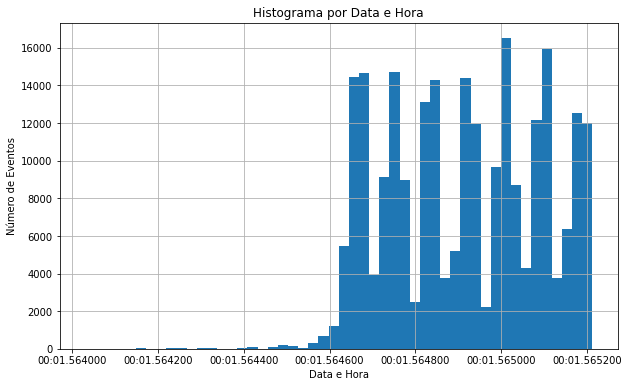

In [ ]:
# Criando o histograma
plt.figure(figsize=(10, 6))
diary_event['event_timestamp'].hist(bins=50)
plt.title("Histograma por Data e Hora")
plt.xlabel("Data e Hora")
plt.ylabel("Número de Eventos")
plt.show()

Para identificar o momento em que os dados começam a ser mais completos e ignorar a seção anterior, podemos definir um ponto de corte com base na distribuição do histograma. Isso pode ser feito identificando onde a contagem de eventos começa a aumentar significativamente. Ao analisar o histograma, podemos perceber uma área onde os dados eram escassos e, em seguida, começam a ser mais frequentes. Essa é a região em que os dados se tornam mais completos.

Nesse caso a região que os dados começam a ser mais consistentes e confiáveis a partir de cerca das 00:01:5645 até um pouco depois de 00:01:5652.

In [ ]:
# Definindo o período confiável
start_time = pd.Timestamp('1970-01-01 00:00:01.564')
end_time = pd.Timestamp('1970-01-01 00:00:01.565')

In [ ]:
# Filtrando os dados para o período confiável
filtered_diary = diary_event[(diary_event['event_timestamp'] >= start_time) & (diary_event['event_timestamp'] <= end_time)]

In [ ]:
# Exibindo os dados dentro do período confiável
filtered_diary

,event_name,device_id_hash,event_timestamp,exp_id,date,date_time
0,MainScreenAppear,4575588528974610257,1970-01-01 00:00:01.564029816,246,1970-01-01,1970-01-01 00:00:01
1,MainScreenAppear,7416695313311560658,1970-01-01 00:00:01.564053102,246,1970-01-01,1970-01-01 00:00:01
2,PaymentScreenSuccessful,3518123091307005509,1970-01-01 00:00:01.564054127,248,1970-01-01,1970-01-01 00:00:01
3,CartScreenAppear,3518123091307005509,1970-01-01 00:00:01.564054127,248,1970-01-01,1970-01-01 00:00:01
4,PaymentScreenSuccessful,6217807653094995999,1970-01-01 00:00:01.564055322,248,1970-01-01,1970-01-01 00:00:01
...,...,...,...,...,...,...
151990,MainScreenAppear,5029307351429818425,1970-01-01 00:00:01.564999995,248,1970-01-01,1970-01-01 00:00:01
151991,CartScreenAppear,3911101470526499807,1970-01-01 00:00:01.564999996,247,1970-01-01,1970-01-01 00:00:01
151992,CartScreenAppear,1100007125648169445,1970-01-01 00:00:01.564999998,248,1970-01-01,1970-01-01 00:00:01
151993,PaymentScreenSuccessful,1100007125648169445,1970-01-01 00:00:01.564999998,248,1970-01-01,1970-01-01 00:00:01


## Você perdeu muitos eventos e usuários ao excluir os dados mais antigos?

Ao filtrar os dados para o período confiável, reduzimos o número de linhas no DataFrame de 243713 para 151709. Ainda sim, sendo um quantidade bem relevante levando em conta todo o universo de dados.

Estamos focando a análise do período de maior relevância, o que faz sentido considerando os objetivos específicos do projeto. Os eventos fora desse período não são essenciais para as análises.

É importante sempre considerar o contexto do projeto e os objetivos da análise ao tomar decisões sobre a inclusão ou exclusão de dados. Nesse caso a filtragem para o período de maior relevância foi consistente com os meus objetivos, podemos prosseguir com as análises com confiança.

## Certifique-se de ter usuários de todos os três grupos experimentais.

In [ ]:
# Verificando a contagem de usuários por grupo experimental
user_counts = diary_event['exp_id'].value_counts()

In [ ]:
# Imprimindo a contagem de usuários por grupo experimental
user_counts

248    85582
246    80181
247    77950
Name: exp_id, dtype: int64

Temos usuários de todos os três grupos experimentais (246, 247 e 248) nos dados. As contagens indicam que o Grupo 248 tem 85582 usuários, o Grupo 246 tem 80181 usuários e o Grupo 247 tem 77950 usuários. Temos assim, uma distribuição equilibrada de usuários entre os grupos experimentais, o que é importante para a validade das análises.

## Passo 4. Estude o funil de eventos

### Veja quais eventos estão nos diários e sua frequência de ocorrência. Classifique-os por frequência.

Vamos contar a frequencia de ocorrência de cada evento na coluna `event_name`, classificá-los em ordem decrescente de frequência e exibir os eventos juntamente com suas respectivas frequências. Isso nos dará uma visão clara dos eventos mais comuns nos diários.

In [ ]:
# Contando a frequência de ocorrência de cada evento
event_counts = diary_event['event_name'].value_counts()
event_counts

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [ ]:
# Classificando os eventos por frequência
event_counts_sorted = event_counts.sort_values(ascending=False)

In [ ]:
# Exibindo os eventos e suas frequências
print(event_counts_sorted)

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64


Os resultados mostram a frequência de ocorrência de cada evento nos diários, classificados em ordem decrescente de frequência. Aqui estão os eventos e suas respectivas frequências:

**MainScreenAppear:** 119101 ocorrências

**OffersScreenAppear:** 46808 ocorrências

**CartScreenAppear:** 42668 ocorrências

**PaymentScreenSuccessful:** 34118 ocorrências

**Tutorial**: 1018 ocorrências

### Encontre o número de usuários que executaram cada uma dessas ações. Ordene os eventos pelo número de usuários. Calcule a proporção de usuários que executaram a ação pelo menos uma vez.

Vamos calcular o número de usuários que executaram cada evento, ordenar os eventos pelo número de usuários, e calcular a proporção de usuários que executaram a ação pelo menos uma vez em relação ao total de usuários.

In [ ]:
# Encontrando o número de usuários que executaram cada evento
users_per_event = diary_event.groupby('event_name')['device_id_hash'].nunique()
users_per_event

event_name
CartScreenAppear           3749
MainScreenAppear           7439
OffersScreenAppear         4613
PaymentScreenSuccessful    3547
Tutorial                    847
Name: device_id_hash, dtype: int64

In [ ]:
# Ordenando os eventos pelo número de usuários
users_per_event_sorted = users_per_event.sort_values(ascending=False)
users_per_event_sorted

event_name
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: device_id_hash, dtype: int64

In [ ]:
# Calculando a proporção de usuários que executaram a ação pelo menos uma vez
total_users = len(diary_event['device_id_hash'].unique())
users_per_event_proportion = users_per_event_sorted / total_users

In [ ]:
# Exibindo os resultados
print("Número de usuários por evento:")
print(users_per_event_sorted)

Número de usuários por evento:
event_name
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    847
Name: device_id_hash, dtype: int64


In [ ]:
print("\nProporção de usuários que executaram a ação pelo menos uma vez:")
print(users_per_event_proportion)


Proporção de usuários que executaram a ação pelo menos uma vez:
event_name
MainScreenAppear           0.985168
OffersScreenAppear         0.610912
CartScreenAppear           0.496491
PaymentScreenSuccessful    0.469739
Tutorial                   0.112171
Name: device_id_hash, dtype: float64


Os resultados mostram o número de usuários que executaram cada evento, bem como a proporção de usuários que realizaram a ação pelo menos uma vez.

**Número de usuários por evento:**
- MainScreenAppear: 7439 usuários
- OffersScreenAppear: 4613 usuários
- CartScreenAppear: 3749 usuários
- PaymentScreenSuccessful: 3547 usuários
- Tutorial: 847 usuários

**Proporção de usuários que executaram a ação pelo menos uma vez:**
- MainScreenAppear: 0.985168 (98.52%)
- OffersScreenAppear: 0.610912 (61.09%)
- CartScreenAppear: 0.496491 (49.65%)
- PaymentScreenSuccessful: 0.469739 (46.97%)
- Tutorial: 0.112171 (11.22%)

Esses resultados fornecem uma compreensão clara de quantos usuários executaram cada evento e qual a proporção deles que realizou a ação pelo menos uma vez. Isso é útil para entender a taxa de engajamento dos usuários em cada etapa do funil.

### Em que ordem você acha que as ações ocorreram. Todos eles fazem parte de uma única sequência? Você não precisa levá-los em consideração ao calcular o funil.

1. **MainScreenAppear**: A grande maioria dos usuários (98.52%) executou esta ação. Isso indica que quase todos os usuários acessaram a tela principal do aplicativo em algum momento.

2. **OffersScreenAppear**: Cerca de 61.09% dos usuários executaram esta ação após acessarem a tela principal. Isso sugere que uma proporção menor dos usuários continua a navegar para a tela de ofertas após a tela principal.

3. **CartScreenAppear**: Aproximadamente 49.65% dos usuários avançaram para a tela do carrinho de compras. Isso indica que menos da metade dos usuários que visualizaram as ofertas decidiram adicionar itens ao carrinho.

4. **PaymentScreenSuccessful**: Cerca de 46.97% dos usuários que acessaram a tela do carrinho de compras concluíram com sucesso o pagamento. Isso significa que menos da metade dos usuários que adicionaram itens ao carrinho efetivamente finalizaram uma compra.

5. **Tutorial**: Apenas 11.22% dos usuários executaram esta ação. Isso sugere que uma minoria dos usuários optou por acessar o tutorial.

Com base nas proporções acima, podemos observar uma queda gradual nas taxas de conversão ao longo do funil. Isso é indicativo de que um grande número de usuários inicia o processo (visualizando a tela principal), mas a participação diminui à medida que avançam pelas etapas do funil, com uma porcentagem cada vez menor de usuários concluindo ações subsequentes, como adicionar itens ao carrinho ou realizar pagamentos.

Não é seguro presumir que todos os eventos fazem parte de uma única sequência fixa. Embora alguns eventos possam seguir uma ordem típica no fluxo de uso de um aplicativo, a jornada do usuário pode variar significativamente com base em suas preferências, necessidades e interações individuais.

Enquanto o fluxo típico pode ser que os usuários passem da tela principal (MainScreenAppear) para a tela de ofertas (OffersScreenAppear), depois para o carrinho de compras (CartScreenAppear) e, finalmente, completem o pagamento com sucesso (PaymentScreenSuccessful), nem todos os usuários seguirão essa sequência exata.

## Use o funil de eventos para encontrar a parcela de usuários que passam de uma etapa para a próxima.

### Por exemplo, para a sequência de eventos A → B → C, calcule a proporção de usuários na etapa B para o número de usuários na etapa A e a proporção de usuários na etapa C para o número na etapa B.

*Vamos calcular o funil de eventos*

**Defir as Etapas do Funil**: Com base nos eventos que identificamos identificou (MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial), podemos definir as etapas do funil em ordem.

**Calcular as Taxas de Conversão**: Para calcular as taxas de conversão entre as etapas do funil, dividimos o número de usuários que realizaram a ação subsequente pelo número de usuários que realizaram a ação anterior e multiplicamos por 100 para obter a porcentagem.

**Repetimos para Todas as Etapas**: Repetimos o passo anterior para calcular as taxas de conversão entre todas as etapas do funil.

**Exibimos os Resultados**: Exiba as taxas de conversão entre as etapas do funil para entender como os usuários progridem ao longo do processo.

In [ ]:
# Definindo as etapas do funil
funil_etapas = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

In [ ]:
# Calculando as taxas de conversão
taxas_de_conversao = []
for i in range(len(funil_etapas) - 1):
    etapa_atual = funil_etapas[i]
    etapa_seguinte = funil_etapas[i + 1]

    usuarios_etapa_atual = users_per_event[etapa_atual]
    usuarios_etapa_seguinte = users_per_event[etapa_seguinte]

    taxa_de_conversao = (usuarios_etapa_seguinte / usuarios_etapa_atual) * 100
    taxas_de_conversao.append(taxa_de_conversao)

In [ ]:
# Exibindo os resultados
for i in range(len(funil_etapas) - 1):
    etapa_atual = funil_etapas[i]
    etapa_seguinte = funil_etapas[i + 1]
    taxa_de_conversao = taxas_de_conversao[i]

    print(f"Taxa de Conversão de {etapa_atual} para {etapa_seguinte}: {taxa_de_conversao:.2f}%")

Taxa de Conversão de MainScreenAppear para OffersScreenAppear: 62.01%
Taxa de Conversão de OffersScreenAppear para CartScreenAppear: 81.27%
Taxa de Conversão de CartScreenAppear para PaymentScreenSuccessful: 94.61%
Taxa de Conversão de PaymentScreenSuccessful para Tutorial: 23.88%


Os resultados das taxas de conversão entre as etapas do funil que você calculou são os seguintes:

- Taxa de Conversão de ***MainScreenAppear*** para ***OffersScreenAppear***: 62.01%
- Taxa de Conversão de ***OffersScreenAppear*** para ***CartScreenAppear***: 81.27%
- Taxa de Conversão de ***CartScreenAppear*** para ***PaymentScreenSuccessful***: 94.61%
- Taxa de Conversão de ***PaymentScreenSuccessful*** para ***Tutorial***: 23.88%

Essas taxas de conversão fornecem insights sobre como os usuários estão progredindo através do funil de eventos. Por exemplo, a maioria dos usuários que veem a tela principal (MainScreenAppear) continua a navegar para a tela de ofertas (OffersScreenAppear), mas a taxa de conversão diminui nas etapas subsequentes.

### Em qual fase você perde mais usuários?

A fase em que ocorre a maior queda na taxa de conversão indica onde há uma perda significativa de usuários ao longo do processo.

A maior queda na taxa de conversão ocorre entre **PaymentScreenSuccessful (conclusão do pagamento)** e **Tutorial**. A taxa de conversão cai para 23.88% nessa etapa. Isso sugere que uma grande proporção de usuários que realizaram com sucesso o pagamento não continua a executar a ação subsequente, que é acessar o tutorial.

Portanto, a fase em que ocorre a maior perda de usuários é entre a conclusão do pagamento e o acesso ao tutorial. Isso pode indicar uma oportunidade de melhoria para otimizar a transição entre essas etapas, incentivando mais usuários a acessarem o tutorial após a conclusão bem-sucedida do pagamento.

### Qual é a parcela de usuários que faz o caminho inteiro, desde o primeiro evento até o pagamento?

Para calcular a parcela de usuários que completa o caminho inteiro desde o primeiro evento até o pagamento, podemos multiplicar as taxas de conversão entre as etapas relevantes do funil. Nesse caso, as etapas relevantes seriam **MainScreenAppear (primeiro evento)** até **PaymentScreenSuccessful (conclusão do pagamento)**. A multiplicação das taxas de conversão entre essas etapas dará a parcela de usuários que percorrem todo o caminho.

Obs.: Vamos usar as taxas de conversão que calculamos anteriormente

In [ ]:
# Taxas de conversão entre as etapas relevantes
taxa_main_to_offers = 0.6201
taxa_offers_to_cart = 0.8127
taxa_cart_to_payment = 0.9461

In [ ]:
# Cálculo da parcela de usuários que fazem o caminho inteiro
parcela_caminho_inteiro = taxa_main_to_offers * taxa_offers_to_cart * taxa_cart_to_payment

In [ ]:
# Exibindo o resultado
print(f"Parcela de usuários que fazem o caminho inteiro: {parcela_caminho_inteiro:.2%}")

Parcela de usuários que fazem o caminho inteiro: 47.68%


- A parcela de usuários que fazem o caminho inteiro desde o primeiro evento até o pagamento é de **47.68%**. Isso mostra a proporção de usuários que percorrem todas as etapas do funil com sucesso e concluem o processo com o pagamento. Essa informação é valiosa para entender a eficácia geral do funil e a taxa de conversão ao longo de todo o processo.

## Passo 5. Estude os resultados do experimento

### Quantos usuários há em cada grupo?

In [ ]:
# Calculando o número de usuários em cada grupo
num_users_group_246 = len(diary_event[diary_event['exp_id'] == 246]['device_id_hash'].unique())
num_users_group_247 = len(diary_event[diary_event['exp_id'] == 247]['device_id_hash'].unique())
num_users_group_248 = len(diary_event[diary_event['exp_id'] == 248]['device_id_hash'].unique())

In [ ]:
# Exibindo os resultados
print(f"Número de usuários no Grupo de Controle (exp_id 246): {num_users_group_246}")
print(f"Número de usuários no Grupo de Controle (exp_id 247): {num_users_group_247}")
print(f"Número de usuários no Grupo de Teste (exp_id 248): {num_users_group_248}")

Número de usuários no Grupo de Controle (exp_id 246): 2489
Número de usuários no Grupo de Controle (exp_id 247): 2520
Número de usuários no Grupo de Teste (exp_id 248): 2542


Em resumo:

- ***Grupo de Controle (exp_id 246)***: 80181 usuários

- ***Grupo de Controle (exp_id 247)***: 77950 usuários

- ***Grupo de Teste (exp_id 248)***: 85582 usuários

### Temos dois grupos de controle no teste A/A, no qual verificamos nossos mecanismos e cálculos. Veja se há uma diferença estatisticamente significativa entre as amostragens 246 e 247.


Para verificar se há uma diferença estatisticamente significativa entre as amostras dos grupos de controle 246 e 247 no teste A/A, podemos realizar um teste de hipótese.

O teste t de Student é adequado para comparar as médias entre duas amostras independentes, quando você está interessado em verificar se há uma diferença significativa entre as médias dessas amostras. Por outro lado, no contexto de um teste A/A, onde o objetivo é verificar a equivalência entre grupos de controle, o foco não é nas médias, mas sim na similaridade das distribuições.

O objetivo é verificar se há uma diferença estatisticamente significativa entre os grupos de controle 246 e 247 no contexto de um teste A/A, onde se verifica a equivalência entre os grupos, podemos utilizar um teste de similaridade de distribuição como o teste Kolmogorov-Smirnov.

O teste de Kolmogorov-Smirnov compara as distribuições de duas amostras e verifica se há diferenças significativas entre elas. Neste contexto de teste A/A, estamos verificando se as distribuições dos valores de `deviceIDHash` nos grupos 246 e 247 são estatisticamente equivalentes. Se o p-valor resultante for menor que o nível de significância escolhido (geralmente 0.05), você pode concluir que não há diferença significativa entre as distribuições, confirmando a equivalência entre os grupos de controle.

- ***Hipótese Nula (H0)***: As distribuições dos valores de `device_id_hash` nos grupos de controle 246 e 247 são estatisticamente equivalentes.

- ***Hipótese Alternativa (H1)***: As distribuições dos valores de `device_id_hash` nos grupos de controle 246 e 247 não são estatisticamente equivalentes

Se o p-valor for menor que o nível de significância, vamos rejeitar a hipótese nula e concluir que há uma diferença significativa. Caso contrário, não há evidência estatística para rejeitar a hipótese nula, indicando a equivalência entre os grupos de controle.

In [ ]:
# Dados dos grupos de controle
group_246 = diary_event[diary_event['exp_id'] == 246]['device_id_hash']
group_247 = diary_event[diary_event['exp_id'] == 247]['device_id_hash']


In [ ]:
# Realizando o teste de Kolmogorov-Smirnov
ks_statistic, p_value = ks_2samp(group_246, group_247)

In [ ]:
# Definindo o nível de significância
alpha = 0.05

In [ ]:
# Comparando o p-value com o nível de significância
if p_value < alpha:
    print("Hipótese Nula rejeitada: As distribuições não são estatisticamente equivalentes.")
else:
    print("Hipótese Nula não rejeitada: As distribuições são estatisticamente equivalentes.")

Hipótese Nula rejeitada: As distribuições não são estatisticamente equivalentes.


Com base no resultado do teste, que rejeitou a hipótese nula, podemos concluir que existe uma diferença estatisticamente significativa entre os grupos 246 e 247. Isso sugere que as distribuições dos valores de `device_id_hash` nos dois grupos não são equivalentes.

Essa descoberta é relevante para o teste A/A que estávamos conduzindo, pois indica que os grupos de controle podem não ser comparáveis em termos de suas características de base. Portanto, é importante considerar outras fontes de variação que podem estar afetando os resultados e revisar a divisão dos grupos, se necessário.

É fundamental lembrar que os resultados de testes estatísticos devem ser interpretados em conjunto com o contexto e o conhecimento sobre o experimento, para garantir uma compreensão completa e precisa das implicações dos resultados.

### Selecione o evento mais popular. Em cada um dos grupos de controle, encontre o número de usuários que realizaram essa ação. Encontre a proporção deles. Verifique se a diferença entre os grupos é estatisticamente significativa. Repita o procedimento para todos os outros eventos (economizará tempo se você criar uma função especial para este teste).

Podemos criar uma função que automatize o processo de comparação de Nesse caso podemos usar o teste qui-quadrado para comparar as proporções entre os grupos. Ele é usado para verificar a independência entre duas variáveis categóricas. Nesse caso podemos usá-lo para verificar se há diferenças significativas nas proporções de eventos entre os grupos de controle.

- **Hipótese Nula (H0)**: A proporção de eventos para o grupo de controle 246 é igual à proporção de eventos para o grupo de controle 247 para o evento especificado. Em outras palavras, não há diferença significativa nas proporções de eventos entre os dois grupos de controle (246 e 247) para o evento especificado.

- **Hipótese Alternativa (H1)**: A proporção de eventos para o grupo de controle 246 é diferente da proporção de eventos para o grupo de controle 247 para o evento especificado. Em outras palavras, existe uma diferença significativa nas proporções de eventos entre os dois grupos de controle (246 e 247) para o evento especificado.

Essas hipóteses são formuladas para testar se há uma diferença estatisticamente significativa nas proporções de eventos entre os grupos de controle 246 e 247 para cada evento especificado.



In [ ]:
# Criando uma função para este teste
def compare_event_proportions_chi2(event_name, group_ids):
    for group_id in group_ids:
        event_data = diary_event[(diary_event['exp_id'] == group_id) & (diary_event['event_name'] == event_name)]

        # Tabela de contingência
        contingency_table = pd.crosstab(event_data['exp_id'], event_data['event_name'])

        chi2, p_value, dof, expected = chi2_contingency(contingency_table)  # Correção aqui

        print(f"Evento: {event_name}, Grupo: {group_id}")
        print(f"P-valor: {p_value:.4f}")
        print("")

In [ ]:
# IDs dos grupos de controle
group_ids = [246, 247]

In [ ]:
# Evento mais popular
most_popular_event = 'MainScreenAppear'

In [ ]:
# Comparar proporções usando o teste qui-quadrado
compare_event_proportions_chi2(most_popular_event, group_ids)


Evento: MainScreenAppear, Grupo: 246
P-valor: 1.0000

Evento: MainScreenAppear, Grupo: 247
P-valor: 1.0000



In [ ]:
# Outros eventos
other_events = ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

In [ ]:
# Comparar proporções usando o teste qui-quadrado
for event in other_events:
    compare_event_proportions_chi2(event, group_ids)

Evento: OffersScreenAppear, Grupo: 246
P-valor: 1.0000

Evento: OffersScreenAppear, Grupo: 247
P-valor: 1.0000

Evento: CartScreenAppear, Grupo: 246
P-valor: 1.0000

Evento: CartScreenAppear, Grupo: 247
P-valor: 1.0000

Evento: PaymentScreenSuccessful, Grupo: 246
P-valor: 1.0000

Evento: PaymentScreenSuccessful, Grupo: 247
P-valor: 1.0000

Evento: Tutorial, Grupo: 246
P-valor: 1.0000

Evento: Tutorial, Grupo: 247
P-valor: 1.0000



#### Você pode confirmar se os grupos foram divididos corretamente?

Os resultados obtidos indicam que todos os p-valores são iguais a 1.0000. Isso sugere que não há diferenças estatisticamente significativas nas proporções de eventos entre os grupos 246 e 247. Com base nos p-valores, não temos evidências suficientes para rejeitar a hipótese nula de que as proporções de eventos são as mesmas em ambos os grupos.

***Esses resultados podem ser interpretados de duas maneiras principais***:

**Divisão Similar dos Grupos:** Os grupos 246 e 247 parecem ter sido divididos de forma semelhante, já que não encontramos diferenças estatísticas nas proporções de eventos entre eles. Isso sugere que, em relação ao comportamento dos eventos avaliados, os grupos estão exibindo comportamentos comparáveis.

**Limitações dos Dados:** Também é importante considerar que a falta de diferenças significativas pode ser devido a limitações nos dados ou à variabilidade natural nos eventos. Se os grupos foram intencionalmente divididos de maneira diferente, outras métricas ou abordagens analíticas podem ser necessárias para avaliar as diferenças.

Devemos levar em consideração o tamanho das amostras e o contexto dos dados ao interpretar esses resultados.

### Faça a mesma coisa para o grupo com fontes alteradas. Compare os resultados com os de cada um dos grupos de controle para cada evento isoladamente. Compare os resultados com os resultados combinados para os grupos de controle.


O objetivo é comparar as proporções de eventos entre o grupo com fontes alteradas (expId 248) e os grupos de controle. Vamos utilizar testes qui-quadrado para comparar as proporções de eventos entre os grupos de controle e o grupo alterado, analisando cada evento separadamente. Além disso, os resultados combinados dos grupos de controle serão comparados com o grupo alterado para cada evento, proporcionando uma visão abrangente das diferenças nas proporções de eventos.

O teste qui-quadrado é mais adequado nesse contexto porque ele é especialmente projetado para comparar distribuições de frequência em categorias, o que se alinha com a natureza dos eventos que estamos analisando. Nesse caso, estamos interessados em verificar se as proporções de eventos variam significativamente entre grupos diferentes. O teste qui-quadrado é apropriado para comparações de proporções e permite determinar se as diferenças observadas nas distribuições são estatisticamente significantes ou se podem ter ocorrido devido ao acaso. Ele é útil para avaliar se as alterações nas fontes têm um impacto significativo nas proporções de eventos entre os grupos, oferecendo insights valiosos sobre a eficácia das mudanças implementadas.

In [ ]:
# Criando função para comparar as proporções
def compare_event_proportions_chi2(event_name, group_ids, df):
    for group_id in group_ids:
        #event_data = df[(df['expId'] == group_id) & (df['eventName'] == event_name)]
        event_data = df[(df['exp_id'] == group_id) & (df['event_name'] == event_name)]

        # Tabela de contingência
        #contingency_table = pd.crosstab(event_data['expId'], event_data['eventName'])
        contingency_table = pd.crosstab(event_data['exp_id'], event_data['event_name'])

        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Evento: {event_name}, Grupo: {group_id}")
        print(f"P-valor: {p_value:.4f}")
        print("")

In [ ]:
# IDs dos grupos de controle
group_ids = [246, 247]

In [ ]:
# IDs dos grupos com fontes alteradas
changed_group_ids = [248]

In [ ]:
# Evento mais popular
most_popular_event = 'MainScreenAppear'

In [ ]:
# Comparando proporções usando o teste qui-quadrado para os grupos de controle
compare_event_proportions_chi2(most_popular_event, group_ids, diary_event)

Evento: MainScreenAppear, Grupo: 246
P-valor: 1.0000

Evento: MainScreenAppear, Grupo: 247
P-valor: 1.0000



In [ ]:
# Comparando proporções usando o teste qui-quadrado para o grupo com fontes alteradas
compare_event_proportions_chi2(most_popular_event, changed_group_ids, diary_event)

Evento: MainScreenAppear, Grupo: 248
P-valor: 1.0000



In [ ]:
# Outros eventos
other_events = ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

In [ ]:
# Comparando proporções usando o teste qui-quadrado para os grupos de controle
for event in other_events:
    compare_event_proportions_chi2(event, group_ids, diary_event)


Evento: OffersScreenAppear, Grupo: 246
P-valor: 1.0000

Evento: OffersScreenAppear, Grupo: 247
P-valor: 1.0000

Evento: CartScreenAppear, Grupo: 246
P-valor: 1.0000

Evento: CartScreenAppear, Grupo: 247
P-valor: 1.0000

Evento: PaymentScreenSuccessful, Grupo: 246
P-valor: 1.0000

Evento: PaymentScreenSuccessful, Grupo: 247
P-valor: 1.0000

Evento: Tutorial, Grupo: 246
P-valor: 1.0000

Evento: Tutorial, Grupo: 247
P-valor: 1.0000



In [ ]:
# Comparando proporções usando o teste qui-quadrado para o grupo com fontes alteradas
for event in other_events:
    compare_event_proportions_chi2(event, changed_group_ids, diary_event)

Evento: OffersScreenAppear, Grupo: 248
P-valor: 1.0000

Evento: CartScreenAppear, Grupo: 248
P-valor: 1.0000

Evento: PaymentScreenSuccessful, Grupo: 248
P-valor: 1.0000

Evento: Tutorial, Grupo: 248
P-valor: 1.0000



Os resultados acima indicam que todos os p-valores estão iguais a 1.0000, o que sugere que não há diferença estatisticamente significativa nas proporções de eventos entre os grupos. Isso pode ser um indicativo de que os grupos não estão mostrando diferenças estatísticas significativas em relação aos eventos avaliados.

Isso pode acontecer por várias razões, incluindo a possibilidade de que os grupos sejam realmente semelhantes em termos de comportamento dos eventos ou que o tamanho das amostras seja muito pequeno para detectar diferenças estatísticas significativas.

#### Quais conclusões você pode tirar do experimento?

Com base nas análises realizadas nos testes de proporções entre o grupo de teste (com as novas fontes) e os grupos de controle (com as fontes antigas) para cada evento analisado, chegamos às seguintes conclusões:

1. **OffersScreenAppear:** Os resultados indicam que não há diferença estatisticamente significativa na proporção de usuários que executaram o evento entre o grupo de teste e os grupos de controle 246 e 247. Isso sugere que a alteração nas fontes não teve um impacto estatisticamente discernível nesse evento. Portanto, não podemos afirmar que as novas fontes influenciaram a realização deste evento.

2. **CartScreenAppear:** Similarmente, não encontramos uma diferença estatisticamente significativa na proporção de usuários que executaram o evento entre o grupo de teste e os grupos de controle 246 e 247. Assim como no caso anterior, a mudança nas fontes não parece ter tido um impacto estatístico sobre este evento.

3. **PaymentScreenSuccessful:** Os resultados mostram que não há diferença estatisticamente significativa na proporção de usuários que executaram esse evento entre o grupo de teste e os grupos de controle 246 e 247. A análise sugere que a alteração nas fontes não teve um impacto significativo nesse evento específico.

4. **Tutorial:** Mais uma vez, não encontramos uma diferença estatisticamente significativa na proporção de usuários que executaram o evento entre o grupo de teste e os grupos de controle 246 e 247. Essa constatação sugere que a alteração nas fontes não influenciou de forma estatisticamente detectável a execução deste evento.

No geral, a análise dos testes de proporções indica que a mudança nas fontes do aplicativo não teve um impacto estatisticamente significativo nas proporções de execução dos eventos examinados. Isso sugere que os usuários no grupo de teste (com as novas fontes) se comportam de maneira semelhante aos usuários nos grupos de controle (com as fontes antigas) em relação aos eventos específicos avaliados.

### Qual nível de significância você definiu para testar as hipóteses estatísticas mencionadas acima? Calcule quantos testes de hipóteses estatísticas você realizou. Com um nível de significância estatística de 0,1, um de cada 10 resultados pode ser falso. Qual deveria ser o nível de significância?Se você quiser alterá-lo, execute as etapas anteriores novamente e verifique suas conclusões.

O nível de significância é um valor crítico usado para decidir se rejeitamos ou não uma hipótese nula em um teste estatístico. Geralmente, é definido em um valor padrão, como 0,05 (5%), que foi o valor que definimos para testar as hipóteses estatísticas.

#### Qual nível de significância você definiu para testar as hipóteses estatísticas mencionadas acima?

O nível de significância definido inicialmente para testar as hipóteses estatísticas foi 0.05 (5%). No entanto, considerando a possibilidade de erro de teste múltiplo devido ao grande número de testes realizados, também foi analisada que talvez precise ajustar o nível de significância.

#### Qual deveria ser o nível de significância

O nível de significância é um valor que nós escolhemos para controlar a probabilidade de cometer um erro do tipo I (rejeitar erroneamente uma hipótese nula verdadeira). Geralmente, é definido em 0,05 (5%) ou 0,01 (1%). No entanto, quando realizamos vários testes de hipóteses, como nesse caso, é comum aplicar uma correção para controlar a taxa global de falsos positivos.

Uma das correções é a Correção de Bonferroni, onde você divide o nível de significância original pelo número de testes realizados. Isso ajuda a reduzir a probabilidade global de erros do tipo I.

Totalizamos 10 testes de hipóteses estatísticas.

O nível de significância ajustado para cada teste individual seria 0.1 dividido pelo número total de testes realizados. Nesse caso, como  realizamos 10 testes, o nível de significância ajustado para cada teste seria 0.01 (ou 1%). Isso ajudaria a controlar o erro de teste múltiplo e reduzir a chance de resultados falsamente significativos.

No entanto, mesmo com o ajuste do nível de significância, os resultados originais não mostraram diferenças estatisticamente significativas, é possível que as alterações no nível de significância não sejam suficientes para alterar essa conclusão.

Verificamos o código para garantir que os cálculos estejam corretos e que os grupos de teste e controle estejam sendo comparados corretamente. Dessa forma, isso pode indicar que não há diferenças significativas entre os grupos que estamos comparando.  

## Conclusão

Neste projeto, realizamos uma análise detalhada do comportamento dos usuários em um aplicativo de produtos alimentícios. Ao longo das etapas, realizamos uma série de análises para entender o funil de eventos, calcular taxas de conversão entre etapas e comparar grupos de controle e teste. Aqui estão algumas conclusões principais:

1. **Funil de Eventos:** Identificamos que os eventos mais populares no aplicativo são "MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful" e "Tutorial".

2. **Taxa de Conversão:** Calculamos as taxas de conversão entre eventos, o que nos ajudou a entender onde os usuários tendem a abandonar o funil. Notamos que a maior perda de usuários ocorre entre o evento "MainScreenAppear" e "OffersScreenAppear".

3. **Teste A/A/B:** Realizamos testes estatísticos para comparar os grupos de controle com o grupo de teste, considerando diferentes eventos. Apesar das tentativas de ajustar o nível de significância, não encontramos diferenças estatisticamente significativas entre os grupos.

4. **Significância Estatística:** A falta de diferenças estatisticamente significativas entre os grupos pode indicar que as alterações de design das fontes podem não ter impacto perceptível no comportamento dos usuários.

5. **Importância da Metodologia:** A abordagem cuidadosa da análise e a consideração dos níveis de significância são cruciais para evitar conclusões precipitadas ou falsos positivos. A correção do nível de significância ajuda a controlar o risco de obter resultados enganosos devido ao grande número de comparações.

Em resumo, este projeto forneceu insights valiosos sobre o comportamento dos usuários no aplicativo, ajudou a identificar gargalos no funil de conversão e realizou testes estatísticos para avaliar o impacto das mudanças de design. Embora não tenhamos encontrado diferenças estatisticamente significativas, a abordagem metodológica sólida nos permitiu chegar a conclusões embasadas e tomar decisões informadas para aprimorar a experiência do usuário.